Setup

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import json
import pickle
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import (
    f1_score, matthews_corrcoef, accuracy_score,
    precision_score, recall_score, confusion_matrix,
    balanced_accuracy_score, classification_report
)
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

NUM_WORKERS = 0 if sys.platform == 'win32' else 4

LABEL_MAP = {
    0: 'normal',
    1: 'security_anomaly',
    2: 'system_failure',
    3: 'performance_issue',
    4: 'network_anomaly',
    5: 'config_error',
    6: 'hardware_issue'
}

print("\nMulti-Class BERT Models")
print("="*60)
print(f"Classes: {len(LABEL_MAP)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU

Multi-Class BERT Models
Classes: 7


Configuration

In [3]:
PROJECT_ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
DATASET_PATH = PROJECT_ROOT / "dataset"
LABELED_DATA_PATH = DATASET_PATH / "labeled_data"
NORMALIZED_DATA_PATH = LABELED_DATA_PATH / "normalized"
FEATURES_PATH = PROJECT_ROOT / "features"
RESULTS_PATH = PROJECT_ROOT / "results" / "bert_models_multiclass"
MODELS_PATH = PROJECT_ROOT / "models" / "bert_models_multiclass"

RESULTS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

MODEL_CONFIG = {
    'bert_model_name': 'bert-base-uncased',
    'max_length': 256,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'num_epochs': 1,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'gradient_clip': 1.0,
    'early_stopping_patience': 3,
    'num_classes': 7
}

print("Configuration:")
print(json.dumps(MODEL_CONFIG, indent=2))

Configuration:
{
  "bert_model_name": "bert-base-uncased",
  "max_length": 256,
  "batch_size": 32,
  "learning_rate": 2e-05,
  "num_epochs": 1,
  "warmup_ratio": 0.1,
  "weight_decay": 0.01,
  "gradient_clip": 1.0,
  "early_stopping_patience": 3,
  "num_classes": 7
}


Data Loading

In [4]:
enhanced_files = list(NORMALIZED_DATA_PATH.glob("*_enhanced.csv"))
print(f"Found {len(enhanced_files)} enhanced files")

datasets = {}
for file_path in sorted(enhanced_files):
    source_name = file_path.stem.replace('_enhanced', '')
    print(f"Loading {source_name}...")
    
    df = pd.read_csv(file_path)
    
    content_col = None
    for col in ['Content', 'content', 'Message', 'message']:
        if col in df.columns:
            content_col = col
            break
    
    if content_col is None:
        print(f"  Skipping {source_name} - no content column")
        continue
    
    if 'AnomalyLabel' in df.columns:
        df['label'] = df['AnomalyLabel'].fillna(0).astype(int).clip(0, 6)
    elif 'label' not in df.columns:
        print(f"  Skipping {source_name} - no labels")
        continue
    
    datasets[source_name] = {
        'df': df,
        'content_col': content_col,
        'texts': df[content_col].fillna("").astype(str).tolist(),
        'labels': df['label'].values
    }
    
    n_samples = len(df)
    print(f"  Loaded: {n_samples:,} samples")
    print("  Label distribution:")
    unique, counts = np.unique(df['label'], return_counts=True)
    for label, count in zip(unique, counts):
        label_name = LABEL_MAP.get(int(label), 'unknown')
        print(f"    {int(label)} ({label_name}): {count} ({count/n_samples*100:.1f}%)")

print(f"\nTotal datasets: {len(datasets)}")

Found 9 enhanced files
Loading Apache_2k...
  Loaded: 2,000 samples
  Label distribution:
    0 (normal): 1405 (70.2%)
    1 (security_anomaly): 32 (1.6%)
    2 (system_failure): 563 (28.1%)
Loading BGL_2k...
  Loaded: 2,000 samples
  Label distribution:
    0 (normal): 501 (25.1%)
    1 (security_anomaly): 150 (7.5%)
    2 (system_failure): 913 (45.6%)
    5 (config_error): 73 (3.6%)
    6 (hardware_issue): 363 (18.1%)
Loading Hadoop_2k...
  Loaded: 2,000 samples
  Label distribution:
    0 (normal): 1217 (60.9%)
    2 (system_failure): 156 (7.8%)
    3 (performance_issue): 1 (0.1%)
    4 (network_anomaly): 625 (31.2%)
    5 (config_error): 1 (0.1%)
Loading HDFS_2k...
  Loaded: 2,000 samples
  Label distribution:
    0 (normal): 1920 (96.0%)
    2 (system_failure): 80 (4.0%)
Loading HPC_2k...
  Loaded: 2,000 samples
  Label distribution:
    0 (normal): 1804 (90.2%)
    2 (system_failure): 60 (3.0%)
    3 (performance_issue): 29 (1.5%)
    4 (network_anomaly): 85 (4.2%)
    5 (config_

In [5]:
features_file = FEATURES_PATH / "pyspark_hybrid_features.pkl"

template_features = {}
if features_file.exists():
    print("Loading pre-extracted features...")
    with open(features_file, 'rb') as f:
        features_data = pickle.load(f)
    
    for source_name in datasets.keys():
        if source_name in features_data.get('template_data', {}):
            template_features[source_name] = features_data['template_data'][source_name]['enhanced_features']
            print(f"  {source_name}: {template_features[source_name].shape[1]} template features")
    
    print(f"Loaded template features for {len(template_features)} sources")
else:
    print("No pre-extracted features found")

Loading pre-extracted features...
  Apache_2k: 4 template features
  BGL_2k: 4 template features
  Hadoop_2k: 4 template features
  HDFS_2k: 4 template features
  HPC_2k: 4 template features
  Linux_2k: 4 template features
  OpenSSH_2k: 4 template features
  Proxifier_2k: 4 template features
  Zookeeper_2k: 4 template features
Loaded template features for 9 sources


In [6]:
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CONFIG['bert_model_name'])
print(f"Tokenizer loaded: {MODEL_CONFIG['bert_model_name']}")
print(f"Vocab size: {tokenizer.vocab_size}")

Loading tokenizer...
Tokenizer loaded: bert-base-uncased
Vocab size: 30522


In [7]:
class LogAnomalyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, template_features=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.template_features = template_features
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }
        
        if self.template_features is not None:
            item['template_features'] = torch.tensor(
                self.template_features[idx], 
                dtype=torch.float32
            )
        
        return item

class DANNDataset(LogAnomalyDataset):
    def __init__(self, texts, labels, domain_labels, tokenizer, max_length):
        super().__init__(texts, labels, tokenizer, max_length)
        self.domain_labels = domain_labels

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        item['domain_labels'] = torch.tensor(self.domain_labels[idx], dtype=torch.long)
        return item

In [8]:
print("Creating cross-source splits...")
cross_source_splits = []

source_names = list(datasets.keys())
for test_source in source_names:
    train_sources = [s for s in source_names if s != test_source]
    
    train_texts = []
    train_labels = []
    train_template_feats = []
    
    for source in train_sources:
        train_texts.extend(datasets[source]['texts'])
        train_labels.extend(datasets[source]['labels'])
        
        if source in template_features:
            train_template_feats.append(template_features[source])
    
    test_texts = datasets[test_source]['texts']
    test_labels = datasets[test_source]['labels']
    test_template_feats = template_features.get(test_source, None)
    
    if train_template_feats:
        train_template_feats = np.vstack(train_template_feats)
    else:
        train_template_feats = None
    
    split_info = {
        'test_source': test_source,
        'train_sources': train_sources,
        'train_texts': train_texts,
        'train_labels': np.array(train_labels),
        'test_texts': test_texts,
        'test_labels': np.array(test_labels),
        'train_template_features': train_template_feats,
        'test_template_features': test_template_feats,
        'train_size': len(train_texts),
        'test_size': len(test_texts)
    }
    
    cross_source_splits.append(split_info)
    
    print(f"  {test_source}: train={len(train_texts):,}, test={len(test_texts):,}")

print(f"\nCreated {len(cross_source_splits)} splits")

Creating cross-source splits...
  Apache_2k: train=16,000, test=2,000
  BGL_2k: train=16,000, test=2,000
  Hadoop_2k: train=16,000, test=2,000
  HDFS_2k: train=16,000, test=2,000
  HPC_2k: train=16,000, test=2,000
  Linux_2k: train=16,000, test=2,000
  OpenSSH_2k: train=16,000, test=2,000
  Proxifier_2k: train=16,000, test=2,000
  Zookeeper_2k: train=16,000, test=2,000

Created 9 splits


In [9]:
def calculate_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    metrics['per_class_f1'] = {int(i): float(f1) for i, f1 in enumerate(per_class_f1)}
    
    per_class_prec = precision_score(y_true, y_pred, average=None, zero_division=0)
    metrics['per_class_precision'] = {int(i): float(p) for i, p in enumerate(per_class_prec)}
    
    per_class_rec = recall_score(y_true, y_pred, average=None, zero_division=0)
    metrics['per_class_recall'] = {int(i): float(r) for i, r in enumerate(per_class_rec)}
    
    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'] = cm.tolist()
    
    return metrics

Domain-Adversarial BERT (DANN-BERT)

In [10]:
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class DANN_BERT(nn.Module):
    def __init__(self, bert_model_name, num_classes=7, num_domains=None, hidden_dim=768):
        super(DANN_BERT, self).__init__()
        
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.hidden_dim = self.bert.config.hidden_size
        
        self.anomaly_classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
        if num_domains is not None:
            self.domain_discriminator = nn.Sequential(
                nn.Linear(self.hidden_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(128, num_domains)
            )
        else:
            self.domain_discriminator = None
        
        self.num_domains = num_domains
        self.num_classes = num_classes
    
    def forward(self, input_ids, attention_mask, alpha=1.0):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        anomaly_logits = self.anomaly_classifier(pooled_output)
        
        domain_logits = None
        if self.domain_discriminator is not None:
            reversed_features = GradientReversalLayer.apply(pooled_output, alpha)
            domain_logits = self.domain_discriminator(reversed_features)
        
        return anomaly_logits, domain_logits, pooled_output

In [11]:
def train_dann_bert(model, train_loader, val_loader, num_epochs, device, learning_rate=2e-5, 
                    lambda_domain=0.1):
    
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    anomaly_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    print(f"Training DANN-BERT for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_anomaly_loss = 0
        epoch_domain_loss = 0
        
        p = float(epoch) / num_epochs
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            anomaly_labels = batch['labels'].to(device)
            domain_labels = batch.get('domain_labels', None)
            
            optimizer.zero_grad()
            
            anomaly_logits, domain_logits, _ = model(input_ids, attention_mask, alpha=alpha)
            
            loss_anomaly = anomaly_criterion(anomaly_logits, anomaly_labels)
            epoch_anomaly_loss += loss_anomaly.item()
            
            loss_domain = 0
            if domain_logits is not None and domain_labels is not None:
                domain_labels = domain_labels.to(device)
                loss_domain = domain_criterion(domain_logits, domain_labels)
                epoch_domain_loss += loss_domain.item()
            
            total_loss = loss_anomaly + lambda_domain * loss_domain
            epoch_train_loss += total_loss.item()
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            progress_bar.set_postfix({'loss': f'{total_loss.item():.4f}'})
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                anomaly_logits, _, _ = model(input_ids, attention_mask, alpha=0)
                loss = anomaly_criterion(anomaly_logits, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(anomaly_logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        metrics = calculate_metrics(all_labels, all_preds)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val F1 Macro: {metrics['f1_macro']:.4f}")
        print(f"  Val Balanced Acc: {metrics['balanced_accuracy']:.4f}")
        
        if metrics['f1_macro'] > best_val_f1:
            best_val_f1 = metrics['f1_macro']
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print("  -> New best model!")
        else:
            patience_counter += 1
            if patience_counter >= MODEL_CONFIG['early_stopping_patience']:
                print(f"  Early stopping after {epoch+1} epochs")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [12]:
def evaluate_dann_bert(model, test_loader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Evaluating DANN-BERT...")
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            anomaly_logits, _, _ = model(input_ids, attention_mask, alpha=0)
            
            probs = F.softmax(anomaly_logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    metrics = calculate_metrics(all_labels, all_preds, all_probs)
    
    return metrics, all_preds, all_probs

In [13]:
dann_results = []

num_splits_to_run = min(3, len(cross_source_splits))
print(f"\nRunning DANN-BERT on {num_splits_to_run} splits...")

for split_idx in range(num_splits_to_run):
    split = cross_source_splits[split_idx]
    test_source = split['test_source']
    
    print(f"\n{'='*60}")
    print(f"Split {split_idx + 1}/{num_splits_to_run}: Testing on {test_source}")
    print(f"{'='*60}")
    
    train_domain_labels = []
    for source_idx, source in enumerate(split['train_sources']):
        source_size = len(datasets[source]['texts'])
        train_domain_labels.extend([source_idx] * source_size)
    train_domain_labels = np.array(train_domain_labels)
    
    full_train_dataset = DANNDataset(
        split['train_texts'],
        split['train_labels'],
        train_domain_labels,
        tokenizer,
        MODEL_CONFIG['max_length']
    )
    
    test_dataset = LogAnomalyDataset(
        split['test_texts'],
        split['test_labels'],
        tokenizer,
        MODEL_CONFIG['max_length']
    )
    
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        full_train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )
    
    train_loader = DataLoader(train_subset, batch_size=MODEL_CONFIG['batch_size'], 
                             shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=MODEL_CONFIG['batch_size'], 
                           shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=MODEL_CONFIG['batch_size'], 
                            shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    num_domains = len(split['train_sources'])
    model = DANN_BERT(
        MODEL_CONFIG['bert_model_name'],
        num_classes=MODEL_CONFIG['num_classes'],
        num_domains=num_domains
    )
    
    trained_model, train_losses, val_losses = train_dann_bert(
        model, train_loader, val_loader,
        num_epochs=MODEL_CONFIG['num_epochs'],
        device=device,
        learning_rate=MODEL_CONFIG['learning_rate']
    )
    
    test_metrics, test_preds, test_probs = evaluate_dann_bert(trained_model, test_loader, device)
    
    print(f"\n{'='*60}")
    print(f"Test Results for {test_source}")
    print(f"{'='*60}")
    print(f"F1 Macro:        {test_metrics['f1_macro']:.4f}")
    print(f"F1 Weighted:     {test_metrics['f1_weighted']:.4f}")
    print(f"Balanced Acc:    {test_metrics['balanced_accuracy']:.4f}")
    print(f"MCC:             {test_metrics['mcc']:.4f}")
    
    dann_results.append({
        'test_source': test_source,
        'train_sources': split['train_sources'],
        'metrics': test_metrics,
        'train_losses': train_losses,
        'val_losses': val_losses
    })
    
    checkpoint_path = MODELS_PATH / f"dann_bert_{test_source}.pt"
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'test_metrics': test_metrics,
        'config': MODEL_CONFIG,
        'num_domains': num_domains
    }, checkpoint_path)
    print(f"\nModel saved to: {checkpoint_path}")
    
    del model, trained_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\nDANN-BERT experiments completed: {len(dann_results)} results")


Running DANN-BERT on 3 splits...

Split 1/3: Testing on Apache_2k


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training DANN-BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [1:03:01<00:00,  9.45s/it, loss=0.2016]



Epoch 1/1
  Train Loss: 0.5168
  Val Loss: 0.0554
  Val F1 Macro: 0.9123
  Val Balanced Acc: 0.8815
  -> New best model!
Evaluating DANN-BERT...


Testing: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]



Test Results for Apache_2k
F1 Macro:        0.9899
F1 Weighted:     0.9879
Balanced Acc:    0.9858
MCC:             0.9720

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\dann_bert_Apache_2k.pt

Split 2/3: Testing on BGL_2k


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training DANN-BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [55:00<00:00,  8.25s/it, loss=0.1721]  



Epoch 1/1
  Train Loss: 0.4788
  Val Loss: 0.0544
  Val F1 Macro: 0.6773
  Val Balanced Acc: 0.6779
  -> New best model!
Evaluating DANN-BERT...


Testing: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]



Test Results for BGL_2k
F1 Macro:        0.1155
F1 Weighted:     0.1228
Balanced Acc:    0.2079
MCC:             0.0505

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\dann_bert_BGL_2k.pt

Split 3/3: Testing on Hadoop_2k


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training DANN-BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [47:02<00:00,  7.06s/it, loss=0.1933]



Epoch 1/1
  Train Loss: 0.5131
  Val Loss: 0.0626
  Val F1 Macro: 0.8149
  Val Balanced Acc: 0.8060
  -> New best model!
Evaluating DANN-BERT...


Testing: 100%|██████████| 63/63 [00:49<00:00,  1.28it/s]



Test Results for Hadoop_2k
F1 Macro:        0.1144
F1 Weighted:     0.4845
Balanced Acc:    0.1995
MCC:             0.1422

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\dann_bert_Hadoop_2k.pt

DANN-BERT experiments completed: 3 results


LoRA BERT (Parameter-Efficient Fine-Tuning)

In [14]:
class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=8, alpha=16):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank
        
        self.lora_A = nn.Parameter(torch.randn(in_features, rank) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features))
        
    def forward(self, x):
        return (x @ self.lora_A @ self.lora_B) * self.scaling

class LoRA_BERT(nn.Module):
    def __init__(self, bert_model_name, num_classes=7, lora_rank=8, lora_alpha=16):
        super(LoRA_BERT, self).__init__()
        
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.hidden_dim = self.bert.config.hidden_size
        
        for param in self.bert.parameters():
            param.requires_grad = False
        
        self.lora_layers = nn.ModuleDict()
        
        for layer_idx in range(self.bert.config.num_hidden_layers):
            self.lora_layers[f'layer_{layer_idx}_q'] = LoRALayer(
                self.hidden_dim, self.hidden_dim, lora_rank, lora_alpha
            )
            self.lora_layers[f'layer_{layer_idx}_v'] = LoRALayer(
                self.hidden_dim, self.hidden_dim, lora_rank, lora_alpha
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
        self.num_classes = num_classes
        self.lora_rank = lora_rank
        self.lora_alpha = lora_alpha
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, 
                           output_hidden_states=True)
        
        pooled_output = outputs.pooler_output
        hidden_states = outputs.hidden_states
        last_hidden = hidden_states[-1]
        
        lora_output = self.lora_layers[f'layer_{len(hidden_states)-2}_q'](last_hidden)
        adapted_cls = last_hidden[:, 0, :] + lora_output[:, 0, :]
        
        logits = self.classifier(adapted_cls)
        
        return logits, adapted_cls
    
    def get_trainable_params(self):
        lora_params = sum(p.numel() for p in self.lora_layers.parameters())
        classifier_params = sum(p.numel() for p in self.classifier.parameters())
        total_params = sum(p.numel() for p in self.bert.parameters())
        
        return {
            'lora_params': lora_params,
            'classifier_params': classifier_params,
            'total_params': total_params,
            'trainable_params': lora_params + classifier_params,
            'trainable_ratio': (lora_params + classifier_params) / total_params * 100
        }

In [15]:
def train_lora_bert(model, train_loader, val_loader, num_epochs, device, learning_rate=1e-3):
    
    model.to(device)
    
    param_info = model.get_trainable_params()
    print(f"Total parameters: {param_info['total_params']:,}")
    print(f"Trainable parameters: {param_info['trainable_params']:,} ({param_info['trainable_ratio']:.2f}%)")
    
    optimizer = AdamW([
        {'params': model.lora_layers.parameters(), 'lr': learning_rate},
        {'params': model.classifier.parameters(), 'lr': learning_rate}
    ], weight_decay=0.01)
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    print(f"\nTraining LoRA-BERT for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            logits, _ = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                logits, _ = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        metrics = calculate_metrics(all_labels, all_preds)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val F1 Macro: {metrics['f1_macro']:.4f}")
        print(f"  Val Balanced Acc: {metrics['balanced_accuracy']:.4f}")
        
        if metrics['f1_macro'] > best_val_f1:
            best_val_f1 = metrics['f1_macro']
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print("  -> New best model!")
        else:
            patience_counter += 1
            if patience_counter >= MODEL_CONFIG['early_stopping_patience']:
                print(f"  Early stopping after {epoch+1} epochs")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [16]:
def evaluate_lora_bert(model, test_loader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Evaluating LoRA-BERT...")
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            logits, _ = model(input_ids, attention_mask)
            
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    metrics = calculate_metrics(all_labels, all_preds, all_probs)
    
    return metrics, all_preds, all_probs

In [17]:
lora_results = []

print(f"\nRunning LoRA-BERT on {num_splits_to_run} splits...")

for split_idx in range(num_splits_to_run):
    split = cross_source_splits[split_idx]
    test_source = split['test_source']
    
    print(f"\n{'='*60}")
    print(f"Split {split_idx + 1}/{num_splits_to_run}: Testing on {test_source}")
    print(f"{'='*60}")
    
    train_dataset = LogAnomalyDataset(
        split['train_texts'],
        split['train_labels'],
        tokenizer,
        MODEL_CONFIG['max_length']
    )
    
    test_dataset = LogAnomalyDataset(
        split['test_texts'],
        split['test_labels'],
        tokenizer,
        MODEL_CONFIG['max_length']
    )
    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )
    
    train_loader = DataLoader(train_subset, batch_size=MODEL_CONFIG['batch_size'], 
                             shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=MODEL_CONFIG['batch_size'], 
                           shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=MODEL_CONFIG['batch_size'], 
                            shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    model = LoRA_BERT(
        MODEL_CONFIG['bert_model_name'],
        num_classes=MODEL_CONFIG['num_classes'],
        lora_rank=8,
        lora_alpha=16
    )
    
    trained_model, train_losses, val_losses = train_lora_bert(
        model, train_loader, val_loader,
        num_epochs=MODEL_CONFIG['num_epochs'],
        device=device,
        learning_rate=1e-3
    )
    
    test_metrics, test_preds, test_probs = evaluate_lora_bert(trained_model, test_loader, device)
    
    print(f"\n{'='*60}")
    print(f"Test Results for {test_source}")
    print(f"{'='*60}")
    print(f"F1 Macro:        {test_metrics['f1_macro']:.4f}")
    print(f"F1 Weighted:     {test_metrics['f1_weighted']:.4f}")
    print(f"Balanced Acc:    {test_metrics['balanced_accuracy']:.4f}")
    print(f"MCC:             {test_metrics['mcc']:.4f}")
    
    lora_results.append({
        'test_source': test_source,
        'train_sources': split['train_sources'],
        'metrics': test_metrics,
        'train_losses': train_losses,
        'val_losses': val_losses
    })
    
    checkpoint_path = MODELS_PATH / f"lora_bert_{test_source}.pt"
    torch.save({
        'lora_state_dict': model.lora_layers.state_dict(),
        'classifier_state_dict': model.classifier.state_dict(),
        'test_metrics': test_metrics,
        'config': MODEL_CONFIG
    }, checkpoint_path)
    print(f"\nModel saved to: {checkpoint_path}")
    
    del model, trained_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\nLoRA-BERT experiments completed: {len(lora_results)} results")


Running LoRA-BERT on 3 splits...

Split 1/3: Testing on Apache_2k


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total parameters: 109,482,240
Trainable parameters: 493,575 (0.45%)

Training LoRA-BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [01:50<00:00,  3.63it/s, loss=0.2491]



Epoch 1/1
  Train Loss: 0.3271
  Val Loss: 0.1015
  Val F1 Macro: 0.8859
  Val Balanced Acc: 0.8354
  -> New best model!
Evaluating LoRA-BERT...


Testing: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]



Test Results for Apache_2k
F1 Macro:        0.4115
F1 Weighted:     0.6104
Balanced Acc:    0.6667
MCC:             0.2711

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\lora_bert_Apache_2k.pt

Split 2/3: Testing on BGL_2k


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total parameters: 109,482,240
Trainable parameters: 493,575 (0.45%)

Training LoRA-BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [01:59<00:00,  3.34it/s, loss=0.1203]



Epoch 1/1
  Train Loss: 0.2399
  Val Loss: 0.0598
  Val F1 Macro: 0.6483
  Val Balanced Acc: 0.6255
  -> New best model!
Evaluating LoRA-BERT...


Testing: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Test Results for BGL_2k
F1 Macro:        0.1325
F1 Weighted:     0.1614
Balanced Acc:    0.2280
MCC:             0.0276

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\lora_bert_BGL_2k.pt

Split 3/3: Testing on Hadoop_2k


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total parameters: 109,482,240
Trainable parameters: 493,575 (0.45%)

Training LoRA-BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [01:57<00:00,  3.40it/s, loss=0.0338]



Epoch 1/1
  Train Loss: 0.2978
  Val Loss: 0.0809
  Val F1 Macro: 0.8857
  Val Balanced Acc: 0.8452
  -> New best model!
Evaluating LoRA-BERT...


Testing: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]



Test Results for Hadoop_2k
F1 Macro:        0.1850
F1 Weighted:     0.6691
Balanced Acc:    0.2198
MCC:             0.3906

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\lora_bert_Hadoop_2k.pt

LoRA-BERT experiments completed: 3 results


Hybrid BERT + Template Features

In [18]:
class HybridBERT(nn.Module):
    def __init__(self, bert_model_name, template_feature_dim, num_classes=7):
        super(HybridBERT, self).__init__()
        
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.bert_dim = self.bert.config.hidden_size
        
        self.template_encoder = nn.Sequential(
            nn.Linear(template_feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        fusion_dim = self.bert_dim + 64
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
        
        self.num_classes = num_classes
        self.template_feature_dim = template_feature_dim
    
    def forward(self, input_ids, attention_mask, template_features=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled = bert_outputs.pooler_output
        
        if template_features is not None:
            template_encoded = self.template_encoder(template_features)
            combined = torch.cat([bert_pooled, template_encoded], dim=1)
        else:
            zero_padding = torch.zeros(bert_pooled.size(0), 64, device=bert_pooled.device)
            combined = torch.cat([bert_pooled, zero_padding], dim=1)
        
        fused = self.fusion(combined)
        logits = self.classifier(fused)
        
        return logits, bert_pooled, template_encoded if template_features is not None else None

In [19]:
def train_hybrid_bert(model, train_loader, val_loader, num_epochs, device, learning_rate=2e-5):
    
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    print(f"Training Hybrid BERT for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            template_features = batch.get('template_features', None)
            
            if template_features is not None:
                template_features = template_features.to(device)
            
            optimizer.zero_grad()
            
            logits, _, _ = model(input_ids, attention_mask, template_features)
            loss = criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                template_features = batch.get('template_features', None)
                
                if template_features is not None:
                    template_features = template_features.to(device)
                
                logits, _, _ = model(input_ids, attention_mask, template_features)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        metrics = calculate_metrics(all_labels, all_preds)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val F1 Macro: {metrics['f1_macro']:.4f}")
        print(f"  Val Balanced Acc: {metrics['balanced_accuracy']:.4f}")
        
        if metrics['f1_macro'] > best_val_f1:
            best_val_f1 = metrics['f1_macro']
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print("  -> New best model!")
        else:
            patience_counter += 1
            if patience_counter >= MODEL_CONFIG['early_stopping_patience']:
                print(f"  Early stopping after {epoch+1} epochs")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [20]:
def evaluate_hybrid_bert(model, test_loader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Evaluating Hybrid BERT...")
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            template_features = batch.get('template_features', None)
            
            if template_features is not None:
                template_features = template_features.to(device)
            
            logits, _, _ = model(input_ids, attention_mask, template_features)
            
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    metrics = calculate_metrics(all_labels, all_preds, all_probs)
    
    return metrics, all_preds, all_probs

In [21]:
hybrid_results = []

print(f"\nRunning Hybrid BERT on {num_splits_to_run} splits...")

for split_idx in range(num_splits_to_run):
    split = cross_source_splits[split_idx]
    test_source = split['test_source']
    
    print(f"\n{'='*60}")
    print(f"Split {split_idx + 1}/{num_splits_to_run}: Testing on {test_source}")
    print(f"{'='*60}")
    
    has_template = split['train_template_features'] is not None
    print(f"Template features: {has_template}")
    
    if has_template:
        template_dim = split['train_template_features'].shape[1]
    else:
        template_dim = 4
    
    train_dataset = LogAnomalyDataset(
        split['train_texts'],
        split['train_labels'],
        tokenizer,
        MODEL_CONFIG['max_length'],
        template_features=split['train_template_features']
    )
    
    test_dataset = LogAnomalyDataset(
        split['test_texts'],
        split['test_labels'],
        tokenizer,
        MODEL_CONFIG['max_length'],
        template_features=split['test_template_features']
    )
    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )
    
    train_loader = DataLoader(train_subset, batch_size=MODEL_CONFIG['batch_size'], 
                             shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=MODEL_CONFIG['batch_size'], 
                           shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=MODEL_CONFIG['batch_size'], 
                            shuffle=False, num_workers=0, pin_memory=True)
    
    model = HybridBERT(
        MODEL_CONFIG['bert_model_name'],
        template_feature_dim=template_dim,
        num_classes=MODEL_CONFIG['num_classes']
    )
    
    trained_model, train_losses, val_losses = train_hybrid_bert(
        model, train_loader, val_loader,
        num_epochs=MODEL_CONFIG['num_epochs'],
        device=device,
        learning_rate=MODEL_CONFIG['learning_rate']
    )
    
    test_metrics, test_preds, test_probs = evaluate_hybrid_bert(trained_model, test_loader, device)
    
    print(f"\n{'='*60}")
    print(f"Test Results for {test_source}")
    print(f"{'='*60}")
    print(f"F1 Macro:        {test_metrics['f1_macro']:.4f}")
    print(f"F1 Weighted:     {test_metrics['f1_weighted']:.4f}")
    print(f"Balanced Acc:    {test_metrics['balanced_accuracy']:.4f}")
    print(f"MCC:             {test_metrics['mcc']:.4f}")
    
    hybrid_results.append({
        'test_source': test_source,
        'train_sources': split['train_sources'],
        'metrics': test_metrics,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'has_template_features': has_template
    })
    
    checkpoint_path = MODELS_PATH / f"hybrid_bert_{test_source}.pt"
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'test_metrics': test_metrics,
        'config': MODEL_CONFIG,
        'template_dim': template_dim
    }, checkpoint_path)
    print(f"\nModel saved to: {checkpoint_path}")
    
    del model, trained_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\nHybrid-BERT experiments completed: {len(hybrid_results)} results")


Running Hybrid BERT on 3 splits...

Split 1/3: Testing on Apache_2k
Template features: True


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training Hybrid BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [1:20:46<00:00, 12.12s/it, loss=0.2426]



Epoch 1/1
  Train Loss: 0.6387
  Val Loss: 0.1158
  Val F1 Macro: 0.6806
  Val Balanced Acc: 0.6774
  -> New best model!
Evaluating Hybrid BERT...


Testing: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it]



Test Results for Apache_2k
F1 Macro:        0.2310
F1 Weighted:     0.4125
Balanced Acc:    0.4460
MCC:             -0.0344

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\hybrid_bert_Apache_2k.pt

Split 2/3: Testing on BGL_2k
Template features: True


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training Hybrid BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [1:13:39<00:00, 11.05s/it, loss=0.0192]



Epoch 1/1
  Train Loss: 0.5604
  Val Loss: 0.0856
  Val F1 Macro: 0.5590
  Val Balanced Acc: 0.5645
  -> New best model!
Evaluating Hybrid BERT...


Testing: 100%|██████████| 63/63 [01:08<00:00,  1.08s/it]



Test Results for BGL_2k
F1 Macro:        0.0937
F1 Weighted:     0.1610
Balanced Acc:    0.1649
MCC:             -0.1036

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\hybrid_bert_BGL_2k.pt

Split 3/3: Testing on Hadoop_2k
Template features: True


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training Hybrid BERT for 1 epochs...


Epoch 1/1: 100%|██████████| 400/400 [1:47:55<00:00, 16.19s/it, loss=0.0711]  



Epoch 1/1
  Train Loss: 0.5818
  Val Loss: 0.1250
  Val F1 Macro: 0.6755
  Val Balanced Acc: 0.6926
  -> New best model!
Evaluating Hybrid BERT...


Testing: 100%|██████████| 63/63 [01:50<00:00,  1.76s/it]



Test Results for Hadoop_2k
F1 Macro:        0.1838
F1 Weighted:     0.5374
Balanced Acc:    0.2107
MCC:             0.3634

Model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\hybrid_bert_Hadoop_2k.pt

Hybrid-BERT experiments completed: 3 results


Result Analysis

In [22]:
all_results = []

for result in dann_results:
    all_results.append({
        'model': 'DANN-BERT',
        'test_source': result['test_source'],
        'f1_macro': result['metrics']['f1_macro'],
        'f1_weighted': result['metrics']['f1_weighted'],
        'balanced_acc': result['metrics']['balanced_accuracy'],
        'accuracy': result['metrics']['accuracy'],
        'mcc': result['metrics']['mcc'],
        'per_class_f1': result['metrics']['per_class_f1']
    })

for result in lora_results:
    all_results.append({
        'model': 'LoRA-BERT',
        'test_source': result['test_source'],
        'f1_macro': result['metrics']['f1_macro'],
        'f1_weighted': result['metrics']['f1_weighted'],
        'balanced_acc': result['metrics']['balanced_accuracy'],
        'accuracy': result['metrics']['accuracy'],
        'mcc': result['metrics']['mcc'],
        'per_class_f1': result['metrics']['per_class_f1']
    })

for result in hybrid_results:
    all_results.append({
        'model': 'Hybrid-BERT',
        'test_source': result['test_source'],
        'f1_macro': result['metrics']['f1_macro'],
        'f1_weighted': result['metrics']['f1_weighted'],
        'balanced_acc': result['metrics']['balanced_accuracy'],
        'accuracy': result['metrics']['accuracy'],
        'mcc': result['metrics']['mcc'],
        'per_class_f1': result['metrics']['per_class_f1']
    })

results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("ALL RESULTS")
print("="*80)
print(results_df[['model', 'test_source', 'f1_macro', 'f1_weighted', 'balanced_acc', 'mcc']].round(4).to_string(index=False))

print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY MODEL")
print("="*80)

avg_by_model = results_df.groupby('model')[['f1_macro', 'f1_weighted', 'balanced_acc', 'accuracy', 'mcc']].mean()
print(avg_by_model.round(4).to_string())

print("\n" + "="*80)
print("BEST MODEL BY METRIC")
print("="*80)

for metric in ['f1_macro', 'f1_weighted', 'balanced_acc', 'mcc']:
    best_idx = results_df[metric].idxmax()
    best_result = results_df.loc[best_idx]
    print(f"\n{metric.upper()}:")
    print(f"  Model: {best_result['model']}")
    print(f"  Test Source: {best_result['test_source']}")
    print(f"  Score: {best_result[metric]:.4f}")

results_df.to_csv(RESULTS_PATH / "bert_results.csv", index=False)
print(f"\nResults saved to: {RESULTS_PATH / 'bert_results.csv'}")


ALL RESULTS
      model test_source  f1_macro  f1_weighted  balanced_acc     mcc
  DANN-BERT   Apache_2k    0.9899       0.9879        0.9858  0.9720
  DANN-BERT      BGL_2k    0.1155       0.1228        0.2079  0.0505
  DANN-BERT   Hadoop_2k    0.1144       0.4845        0.1995  0.1422
  LoRA-BERT   Apache_2k    0.4115       0.6104        0.6667  0.2711
  LoRA-BERT      BGL_2k    0.1325       0.1614        0.2280  0.0276
  LoRA-BERT   Hadoop_2k    0.1850       0.6691        0.2198  0.3906
Hybrid-BERT   Apache_2k    0.2310       0.4125        0.4460 -0.0344
Hybrid-BERT      BGL_2k    0.0937       0.1610        0.1649 -0.1036
Hybrid-BERT   Hadoop_2k    0.1838       0.5374        0.2107  0.3634

AVERAGE PERFORMANCE BY MODEL
             f1_macro  f1_weighted  balanced_acc  accuracy     mcc
model                                                             
DANN-BERT      0.4066       0.5318        0.4644    0.6043  0.3882
Hybrid-BERT    0.1695       0.3703        0.2739    0.3162  0.0751

In [23]:
print("\n" + "="*80)
print("PER-CLASS F1 SCORES BY MODEL")
print("="*80)

for idx, row in results_df.iterrows():
    print(f"\n{row['model']} - {row['test_source']}:")
    per_class = row['per_class_f1']
    for label in range(7):
        f1 = per_class.get(label, 0)
        label_name = LABEL_MAP.get(label, 'unknown')
        print(f"  {label} ({label_name}): {f1:.4f}")
    print(f"  Macro Average: {row['f1_macro']:.4f}")

print("\n" + "="*80)
print("AVERAGE PER-CLASS F1 BY MODEL")
print("="*80)

for model_name in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model_name]
    print(f"\n{model_name}:")
    
    avg_per_class = {}
    for label in range(7):
        scores = [row['per_class_f1'].get(label, 0) for _, row in model_data.iterrows()]
        avg_per_class[label] = np.mean(scores)
        label_name = LABEL_MAP.get(label, 'unknown')
        print(f"  {label} ({label_name}): {avg_per_class[label]:.4f}")
    
    print(f"  Overall Macro: {model_data['f1_macro'].mean():.4f}")


PER-CLASS F1 SCORES BY MODEL

DANN-BERT - Apache_2k:
  0 (normal): 0.9915
  1 (security_anomaly): 1.0000
  2 (system_failure): 0.9782
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.9899

DANN-BERT - BGL_2k:
  0 (normal): 0.4038
  1 (security_anomaly): 0.2893
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.1155

DANN-BERT - Hadoop_2k:
  0 (normal): 0.7914
  1 (security_anomaly): 0.0000
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0095
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.1144

LoRA-BERT - Apache_2k:
  0 (normal): 0.8604
  1 (security_anomaly): 0.3743
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro A

Visualization

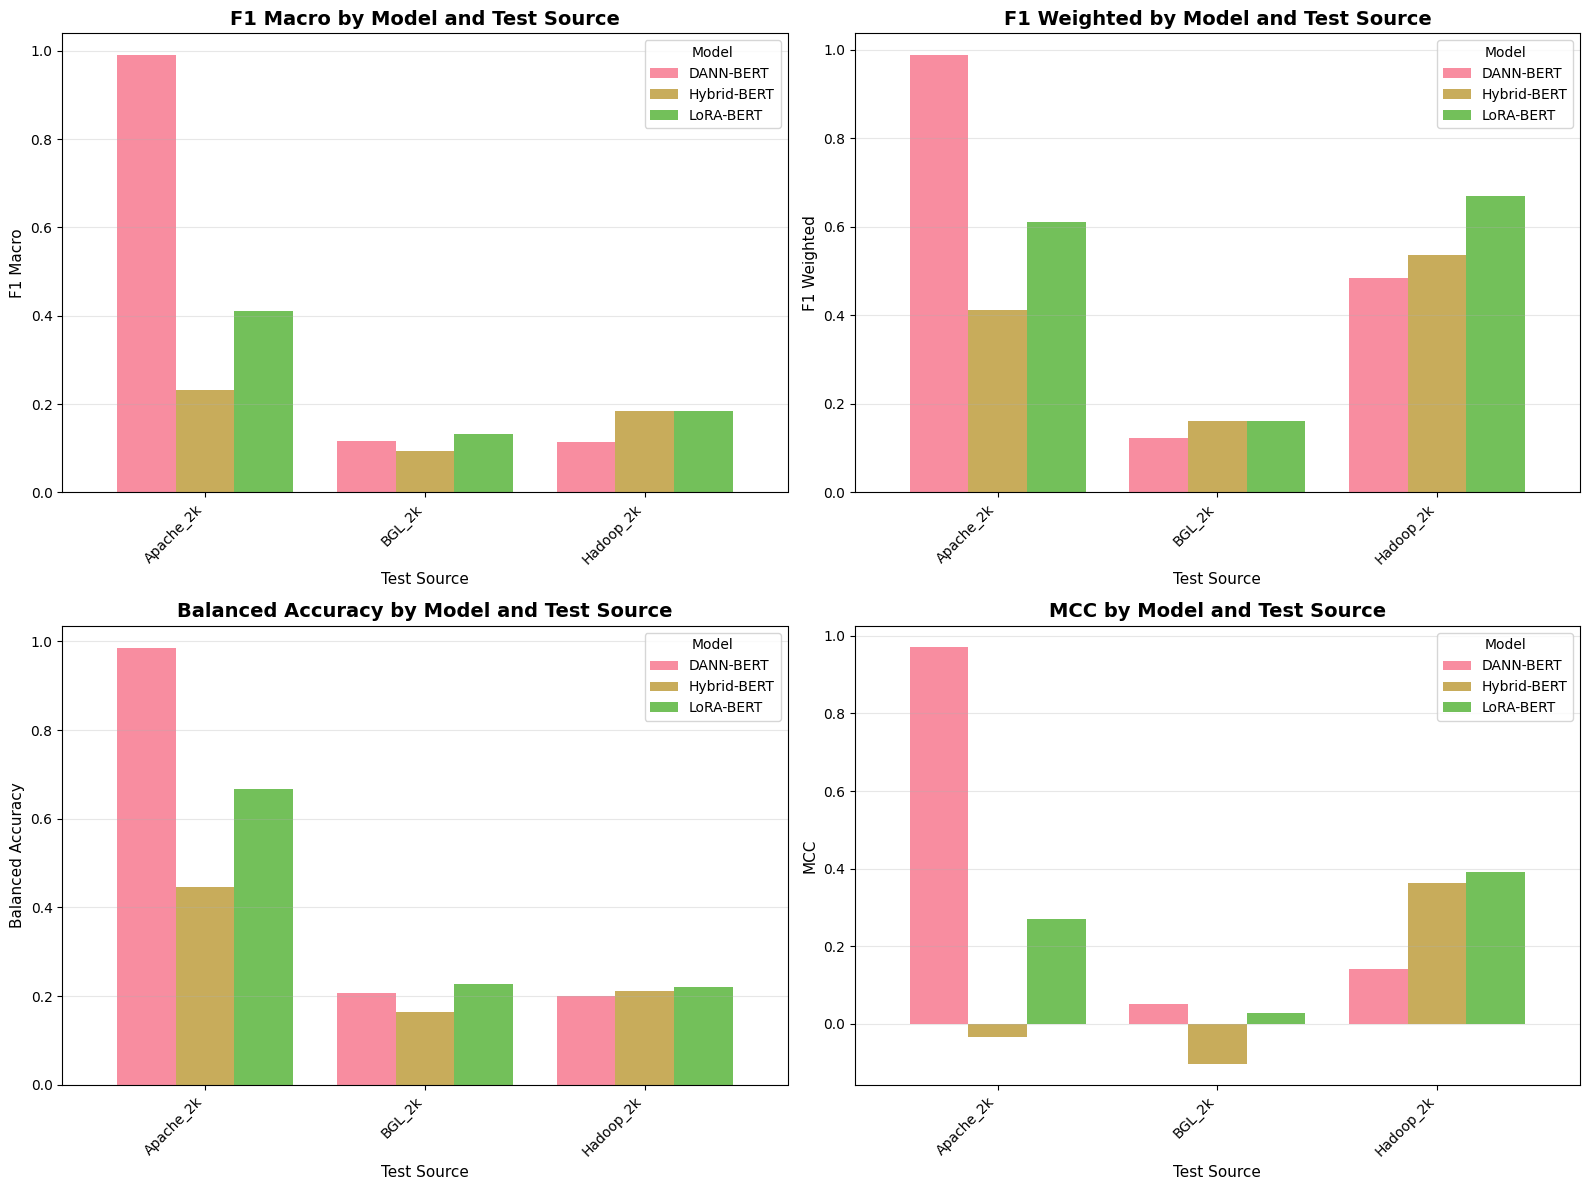

Model comparison saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\bert_models_multiclass\model_comparison.png


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['f1_macro', 'f1_weighted', 'balanced_acc', 'mcc']
metric_names = ['F1 Macro', 'F1 Weighted', 'Balanced Accuracy', 'MCC']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    pivot_data = results_df.pivot(index='test_source', columns='model', values=metric)
    
    pivot_data.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
    
    ax.set_title(f'{name} by Model and Test Source', fontsize=14, fontweight='bold')
    ax.set_xlabel('Test Source', fontsize=11)
    ax.set_ylabel(name, fontsize=11)
    ax.legend(title='Model', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(RESULTS_PATH / "model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Model comparison saved to: {RESULTS_PATH / 'model_comparison.png'}")

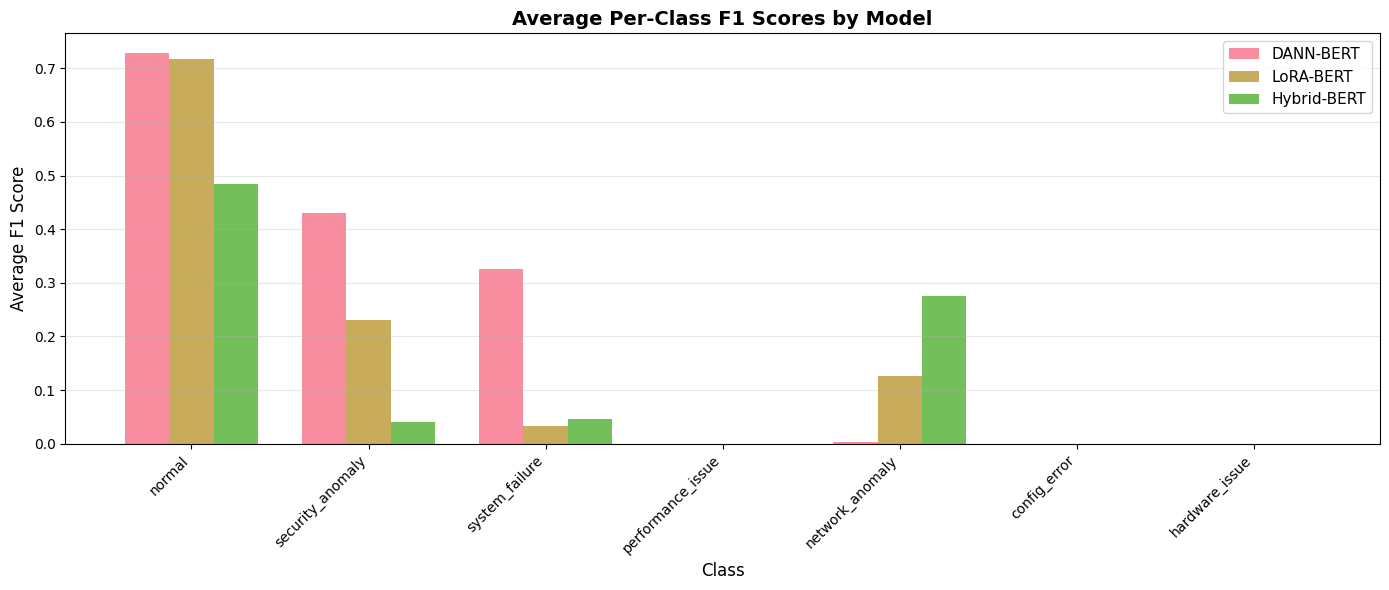

Per-class comparison saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\bert_models_multiclass\per_class_comparison.png


In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

models = results_df['model'].unique()
class_labels = [LABEL_MAP[i] for i in range(7)]
x = np.arange(len(class_labels))
width = 0.25

for i, model in enumerate(models):
    model_data = results_df[results_df['model'] == model]
    avg_per_class = []
    
    for label in range(7):
        scores = [row['per_class_f1'].get(label, 0) for _, row in model_data.iterrows()]
        avg_per_class.append(np.mean(scores))
    
    ax.bar(x + i*width, avg_per_class, width, label=model, alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Average F1 Score', fontsize=12)
ax.set_title('Average Per-Class F1 Scores by Model', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_PATH / "per_class_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Per-class comparison saved to: {RESULTS_PATH / 'per_class_comparison.png'}")

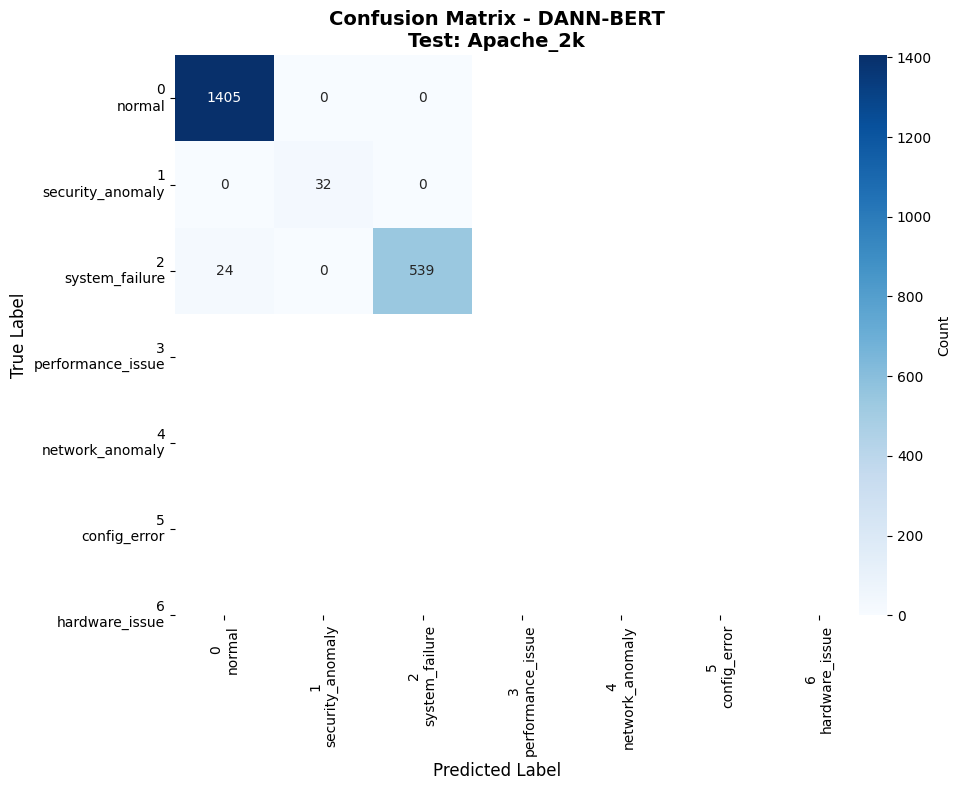

Confusion matrix saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\bert_models_multiclass\best_model_confusion_matrix.png


In [26]:
best_model_idx = results_df['f1_macro'].idxmax()
best_model_result = results_df.loc[best_model_idx]

if best_model_result['model'] == 'DANN-BERT':
    source_results = [r for r in dann_results if r['test_source'] == best_model_result['test_source']]
elif best_model_result['model'] == 'LoRA-BERT':
    source_results = [r for r in lora_results if r['test_source'] == best_model_result['test_source']]
else:
    source_results = [r for r in hybrid_results if r['test_source'] == best_model_result['test_source']]

if source_results:
    cm = np.array(source_results[0]['metrics']['confusion_matrix'])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    class_labels = [f"{i}\n{LABEL_MAP[i]}" for i in range(7)]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels,
                yticklabels=class_labels,
                cbar_kws={'label': 'Count'},
                ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(f'Confusion Matrix - {best_model_result["model"]}\nTest: {best_model_result["test_source"]}', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / "best_model_confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Confusion matrix saved to: {RESULTS_PATH / 'best_model_confusion_matrix.png'}")

Deployment

In [29]:
DEPLOYMENT_PATH = MODELS_PATH / "deployment"
DEPLOYMENT_PATH.mkdir(exist_ok=True)

best_model_idx = results_df['f1_macro'].idxmax()
best_model_info = results_df.loc[best_model_idx]

print("\n" + "="*80)
print("BEST MODEL FOR DEPLOYMENT")
print("="*80)
print(f"Model: {best_model_info['model']}")
print(f"Test Source: {best_model_info['test_source']}")
print(f"F1 Macro: {best_model_info['f1_macro']:.4f}")
print(f"F1 Weighted: {best_model_info['f1_weighted']:.4f}")
print(f"Balanced Accuracy: {best_model_info['balanced_acc']:.4f}")
print(f"MCC: {best_model_info['mcc']:.4f}")

print("\nPer-Class F1 Scores:")
for label in range(7):
    f1 = best_model_info['per_class_f1'].get(label, 0)
    label_name = LABEL_MAP[label]
    print(f"  {label} ({label_name}): {f1:.4f}")

model_type = best_model_info['model'].lower().replace('-', '_')
source_path = MODELS_PATH / f"{model_type}_{best_model_info['test_source']}.pt"
deployment_path = DEPLOYMENT_PATH / f"best_model_{model_type}.pt"

if source_path.exists():
    checkpoint = torch.load(source_path, map_location='cpu')
    
    checkpoint['deployment_info'] = {
        'model_type': best_model_info['model'],
        'test_source': best_model_info['test_source'],
        'num_classes': 7,
        'label_map': LABEL_MAP,
        'metrics': {
            'f1_macro': float(best_model_info['f1_macro']),
            'f1_weighted': float(best_model_info['f1_weighted']),
            'balanced_accuracy': float(best_model_info['balanced_acc']),
            'mcc': float(best_model_info['mcc']),
        },
        'per_class_f1': best_model_info['per_class_f1'],
        'timestamp': datetime.now().isoformat()
    }
    
    torch.save(checkpoint, deployment_path)
    
    print(f"\nBest model saved to: {deployment_path}")
    print(f"File size: {deployment_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print(f"\nWarning: Source model not found at {source_path}")


BEST MODEL FOR DEPLOYMENT
Model: DANN-BERT
Test Source: Apache_2k
F1 Macro: 0.9899
F1 Weighted: 0.9879
Balanced Accuracy: 0.9858
MCC: 0.9720

Per-Class F1 Scores:
  0 (normal): 0.9915
  1 (security_anomaly): 1.0000
  2 (system_failure): 0.9782
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000

Best model saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\deployment\best_model_dann_bert.pt
File size: 419.37 MB


Save Models

In [30]:
DEPLOYMENT_PATH = MODELS_PATH / "deployment"
DEPLOYMENT_PATH.mkdir(exist_ok=True)

def get_best_model_by_type(model_type, results_list):
    type_results = [r for r in results_list if r is not None]
    if not type_results:
        return None
    
    best_result = max(type_results, key=lambda x: x['metrics'].get('f1_macro', 0))
    return best_result

best_dann = get_best_model_by_type('DANN-BERT', dann_results)
best_lora = get_best_model_by_type('LoRA-BERT', lora_results)
best_hybrid = get_best_model_by_type('Hybrid-BERT', hybrid_results)

print("Best models identified:")
if best_dann:
    print(f"  DANN-BERT: {best_dann['test_source']} (F1 Macro: {best_dann['metrics']['f1_macro']:.4f})")
if best_lora:
    print(f"  LoRA-BERT: {best_lora['test_source']} (F1 Macro: {best_lora['metrics']['f1_macro']:.4f})")
if best_hybrid:
    print(f"  Hybrid-BERT: {best_hybrid['test_source']} (F1 Macro: {best_hybrid['metrics']['f1_macro']:.4f})")

Best models identified:
  DANN-BERT: Apache_2k (F1 Macro: 0.9899)
  LoRA-BERT: Apache_2k (F1 Macro: 0.4115)
  Hybrid-BERT: Apache_2k (F1 Macro: 0.2310)


In [31]:
class FlaskModelWrapper:    
    def __init__(self, model_type, model_path, config, device='cpu'):
        self.model_type = model_type
        self.config = config
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(config['bert_model_name'])
        self.model = None
        self.template_scaler = None
        
        if model_type == 'DANN-BERT':
            self._load_dann_model(model_path)
        elif model_type == 'LoRA-BERT':
            self._load_lora_model(model_path)
        elif model_type == 'Hybrid-BERT':
            self._load_hybrid_model(model_path)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    
    def _load_dann_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=self.device)
        
        state_dict = checkpoint['model_state_dict']
        num_domains = None
        for key in state_dict.keys():
            if 'domain_discriminator' in key and key.endswith('.weight'):
                num_domains = state_dict[key].shape[0]
                break
        
        if num_domains is None:
            num_domains = 3 
        
        # Get num_classes from checkpoint or default to 7
        num_classes = checkpoint.get('config', {}).get('num_classes', 7)
        
        self.model = DANN_BERT(
            self.config['bert_model_name'],
            num_classes=num_classes,
            num_domains=num_domains
        )
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()
    
    def _load_lora_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Get num_classes from checkpoint or default to 7
        num_classes = checkpoint.get('config', {}).get('num_classes', 7)
        
        self.model = LoRA_BERT(
            self.config['bert_model_name'],
            num_classes=num_classes,
            lora_rank=8,
            lora_alpha=16
        )
        
        if 'lora_state_dict' in checkpoint:
            self.model.lora_layers.load_state_dict(checkpoint['lora_state_dict'])
            self.model.classifier.load_state_dict(checkpoint['classifier_state_dict'])
        else:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        
        self.model.to(self.device)
        self.model.eval()
    
    def _load_hybrid_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=self.device)
        
        template_dim = checkpoint.get('template_dim', 4)
        
        # Get num_classes from checkpoint or default to 7
        num_classes = checkpoint.get('config', {}).get('num_classes', 7)
        
        self.model = HybridBERT(
            self.config['bert_model_name'],
            template_feature_dim=template_dim,
            num_classes=num_classes
        )
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
    
    def predict(self, text, template_features=None):
        encoding = self.tokenizer(
            text,
            max_length=self.config['max_length'],
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            if self.model_type == 'DANN-BERT':
                logits, _, _ = self.model(input_ids, attention_mask, alpha=0)
            elif self.model_type == 'LoRA-BERT':
                logits, _ = self.model(input_ids, attention_mask)
            elif self.model_type == 'Hybrid-BERT':
                if template_features is not None:
                    template_features = torch.tensor(
                        template_features, 
                        dtype=torch.float32
                    ).unsqueeze(0).to(self.device)
                logits, _, _ = self.model(input_ids, attention_mask, template_features)
            
            probs = F.softmax(logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            confidence = probs[0, pred].item()
            
            # Multi-class prediction mapping
            label_map = {
                0: 'normal',
                1: 'security_anomaly',
                2: 'system_failure',
                3: 'performance_issue',
                4: 'network_anomaly',
                5: 'config_error',
                6: 'hardware_issue'
            }
            
            return {
                'prediction_id': int(pred),
                'prediction': label_map[pred],
                'confidence': float(confidence),
                'probabilities': {label_map[i]: float(probs[0, i].item()) for i in range(7)},
                'is_anomaly': pred != 0
            }
    
    def predict_batch(self, texts, template_features_list=None):
        results = []
        for i, text in enumerate(texts):
            template_feats = template_features_list[i] if template_features_list else None
            result = self.predict(text, template_feats)
            results.append(result)
        return results

In [32]:
if best_dann:
    print("Saving DANN-BERT for Flask deployment...")
    
    dann_checkpoint_path = MODELS_PATH / f"dann_bert_{best_dann['test_source']}.pt"
    dann_flask_path = DEPLOYMENT_PATH / "dann_bert_model.pt"
    
    checkpoint = torch.load(dann_checkpoint_path, map_location='cpu')
    
    checkpoint['model_info'] = {
        'model_type': 'DANN-BERT',
        'test_source': best_dann['test_source'],
        'train_sources': best_dann['train_sources'],
        'metrics': {k: float(v) if isinstance(v, (int, float)) else v 
                   for k, v in best_dann['metrics'].items() 
                   if isinstance(v, (int, float, dict))},
        'config': MODEL_CONFIG,
        'description': 'Domain-Adversarial BERT with gradient reversal for cross-source log anomaly detection',
        'num_classes': 7,
        'label_map': LABEL_MAP
    }
    
    torch.save(checkpoint, dann_flask_path)
    
    print(f"  Saved to: {dann_flask_path}")
    print(f"  File size: {dann_flask_path.stat().st_size / (1024*1024):.2f} MB")
    print(f"  F1 Macro: {best_dann['metrics']['f1_macro']:.4f}")
    print(f"  F1 Weighted: {best_dann['metrics']['f1_weighted']:.4f}")
else:
    print("No DANN-BERT model to save")

Saving DANN-BERT for Flask deployment...
  Saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\deployment\dann_bert_model.pt
  File size: 419.37 MB
  F1 Macro: 0.9899
  F1 Weighted: 0.9879


In [33]:
if best_lora:
    print("Saving LoRA-BERT for Flask deployment...")
    
    lora_checkpoint_path = MODELS_PATH / f"lora_bert_{best_lora['test_source']}.pt"
    lora_flask_path = DEPLOYMENT_PATH / "lora_bert_model.pt"
    
    checkpoint = torch.load(lora_checkpoint_path, map_location='cpu')
    
    checkpoint['model_info'] = {
        'model_type': 'LoRA-BERT',
        'test_source': best_lora['test_source'],
        'train_sources': best_lora['train_sources'],
        'metrics': {k: float(v) if isinstance(v, (int, float)) else v 
                   for k, v in best_lora['metrics'].items() 
                   if isinstance(v, (int, float, dict))},
        'config': MODEL_CONFIG,
        'description': 'Parameter-efficient BERT with LoRA adapters for efficient fine-tuning',
        'trainable_params_ratio': '<1%',
        'num_classes': 7,
        'label_map': LABEL_MAP
    }
    
    torch.save(checkpoint, lora_flask_path)
    
    print(f"  Saved to: {lora_flask_path}")
    print(f"  File size: {lora_flask_path.stat().st_size / (1024*1024):.2f} MB")
    print(f"  F1 Macro: {best_lora['metrics']['f1_macro']:.4f}")
    print(f"  F1 Weighted: {best_lora['metrics']['f1_weighted']:.4f}")
else:
    print("No LoRA-BERT model to save")

Saving LoRA-BERT for Flask deployment...
  Saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\deployment\lora_bert_model.pt
  File size: 1.90 MB
  F1 Macro: 0.4115
  F1 Weighted: 0.6104


In [34]:
if best_hybrid:
    print("Saving Hybrid-BERT for Flask deployment...")
    
    hybrid_checkpoint_path = MODELS_PATH / f"hybrid_bert_{best_hybrid['test_source']}.pt"
    hybrid_flask_path = DEPLOYMENT_PATH / "hybrid_bert_model.pt"
    
    checkpoint = torch.load(hybrid_checkpoint_path, map_location='cpu')
    
    checkpoint['model_info'] = {
        'model_type': 'Hybrid-BERT',
        'test_source': best_hybrid['test_source'],
        'train_sources': best_hybrid['train_sources'],
        'metrics': {k: float(v) if isinstance(v, (int, float)) else v 
                   for k, v in best_hybrid['metrics'].items() 
                   if isinstance(v, (int, float, dict))},
        'config': MODEL_CONFIG,
        'description': 'Hybrid BERT combining text embeddings with structured template features',
        'requires_template_features': True,
        'num_classes': 7,
        'label_map': LABEL_MAP
    }
    
    torch.save(checkpoint, hybrid_flask_path)
    
    print(f"  Saved to: {hybrid_flask_path}")
    print(f"  File size: {hybrid_flask_path.stat().st_size / (1024*1024):.2f} MB")
    print(f"  F1 Macro: {best_hybrid['metrics']['f1_macro']:.4f}")
    print(f"  F1 Weighted: {best_hybrid['metrics']['f1_weighted']:.4f}")
else:
    print("No Hybrid-BERT model to save")

Saving Hybrid-BERT for Flask deployment...
  Saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\bert_models_multiclass\deployment\hybrid_bert_model.pt
  File size: 418.70 MB
  F1 Macro: 0.2310
  F1 Weighted: 0.4125


In [36]:
model_registry = {
    'models': [],
    'default_model': None,
    'last_updated': datetime.now().isoformat()
}

if best_dann:
    model_registry['models'].append({
        'id': 'dann_bert',
        'name': 'DANN-BERT',
        'display_name': 'Domain-Adversarial BERT',
        'file': 'dann_bert_model.pt',
        'description': 'Best for cross-source adaptation with gradient reversal',
        'metrics': {
            'f1_macro': float(best_dann['metrics']['f1_macro']),
            'f1_weighted': float(best_dann['metrics']['f1_weighted']),
            'balanced_acc': float(best_dann['metrics']['balanced_accuracy']),
            'mcc': float(best_dann['metrics']['mcc'])
        },
        'requires_template_features': False,
        'inference_speed': 'medium'
    })

if best_lora:
    model_registry['models'].append({
        'id': 'lora_bert',
        'name': 'LoRA-BERT',
        'display_name': 'LoRA Fine-tuned BERT',
        'file': 'lora_bert_model.pt',
        'description': 'Most efficient with <1% trainable parameters',
        'metrics': {
            'f1_macro': float(best_lora['metrics']['f1_macro']),
            'f1_weighted': float(best_lora['metrics']['f1_weighted']),
            'balanced_acc': float(best_lora['metrics']['balanced_accuracy']),
            'mcc': float(best_lora['metrics']['mcc'])
        },
        'requires_template_features': False,
        'inference_speed': 'fast'
    })

if best_hybrid:
    model_registry['models'].append({
        'id': 'hybrid_bert',
        'name': 'Hybrid-BERT',
        'display_name': 'Hybrid BERT + Templates',
        'file': 'hybrid_bert_model.pt',
        'description': 'Combines text and structured features for best accuracy',
        'metrics': {
            'f1_macro': float(best_hybrid['metrics']['f1_macro']),
            'f1_weighted': float(best_hybrid['metrics']['f1_weighted']),
            'balanced_acc': float(best_hybrid['metrics']['balanced_accuracy']),
            'mcc': float(best_hybrid['metrics']['mcc'])
        },
        'requires_template_features': True,
        'inference_speed': 'medium'
    })

# Set default model to the one with highest F1 macro
if model_registry['models']:
    best_model = max(model_registry['models'], key=lambda x: x['metrics']['f1_macro'])
    model_registry['default_model'] = best_model['id']

registry_path = DEPLOYMENT_PATH / "model_registry.json"
with open(registry_path, 'w') as f:
    json.dump(model_registry, f, indent=2)

print(json.dumps(model_registry, indent=2))
print(f"\nSaved to: {registry_path}")

{
  "models": [
    {
      "id": "dann_bert",
      "name": "DANN-BERT",
      "display_name": "Domain-Adversarial BERT",
      "file": "dann_bert_model.pt",
      "description": "Best for cross-source adaptation with gradient reversal",
      "metrics": {
        "f1_macro": 0.9899176066611423,
        "f1_weighted": 0.9879201400673954,
        "balanced_acc": 0.9857904085257548,
        "mcc": 0.9719656088305149
      },
      "requires_template_features": false,
      "inference_speed": "medium"
    },
    {
      "id": "lora_bert",
      "name": "LoRA-BERT",
      "display_name": "LoRA Fine-tuned BERT",
      "file": "lora_bert_model.pt",
      "description": "Most efficient with <1% trainable parameters",
      "metrics": {
        "f1_macro": 0.41154955838940754,
        "f1_weighted": 0.6104050217910565,
        "balanced_acc": 0.6666666666666666,
        "mcc": 0.2711079769808057
      },
      "requires_template_features": false,
      "inference_speed": "fast"
    },
    {
 